In [1]:
%matplotlib inline
import pandas as pd
from getdist import plots
from getdist import MCSamples

import matplotlib.pyplot as plt
import numpy as np


import os
import corner
from chainconsumer import ChainConsumer

from IPython.display import display, Math
from numcosmo_py import Nc
from numcosmo_py import Ncm, GObject


# CCL
import pyccl as ccl
from pyccl.halos.massdef import MassDef

import sys 
import math 
from emantis.halo_mass_function import HMFEmulator




## CCL versus NC

In [2]:
Omega_c = 0.262 
Omega_b = 0.049 
Omega_k = 0.0 
H0      = 67.66
h       = H0 / 100.0
Tcmb0   = 2.7255 
A_s     = 2.1e-9 
sigma8  = 0.8277 
n_s     = 0.96 
Neff    = 3.046
w0      = -1.0 
wa      = 0.0 
Tinker_lin_interp = True
area = 439.78986
Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

In [3]:
Ob0 = Omega_b
Odm0 = Omega_c


cosmo = Nc.HICosmoDEXcdm()
reion = Nc.HIReionCamb.new()
prim = Nc.HIPrimPowerLaw.new()

cosmo.add_submodel(reion)
cosmo.add_submodel(prim)
dist = Nc.Distance.new(2.0)
tf = Nc.TransferFuncEH.new()
psml = Nc.PowspecMLTransfer.new(tf)
    # psml = Nc.PowspecMLCBE.new ()
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)
psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)
cosmo.omega_x2omega_k()
cosmo.param_set_by_name("Omegak", 0.0)

mulf = Nc.MultiplicityFuncTinker.new()
mulf.set_linear_interp(True)  # This reproduces the linear interpolation done in CCL
mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
mulf.set_Delta(200)

hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
hmf.set_area_sd(area)
psf = hmf.peek_psf ()
psf.prepare (cosmo)
sigma8_nc = psf.eval_sigma (0.0, 8.0 / h)

hmf.set_eval_limits (cosmo, math.log (1e11), math.log(1e16), 0.0, 2.0)
hmf.prepare (cosmo)

In [4]:
cosmo_ccl = ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, Neff=Neff,
                          h=h, sigma8=sigma8, n_s=n_s, Omega_k=Omega_k,
                          w0=w0, wa=wa, T_CMB=Tcmb0, m_nu=[0.00, 0.0, 0.0], 
                          transfer_function='eisenstein_hu', matter_power_spectrum='linear')
ccl_hmf_T08 = ccl.halos.MassFuncTinker08(mass_def='200c')

In [5]:
# Array of masses
m_arr = np.geomspace(1e13,1e14,128)

# Array of redshifts
z_arr = np.linspace(0.0,1.0,16)

<Figure size 640x480 with 0 Axes>

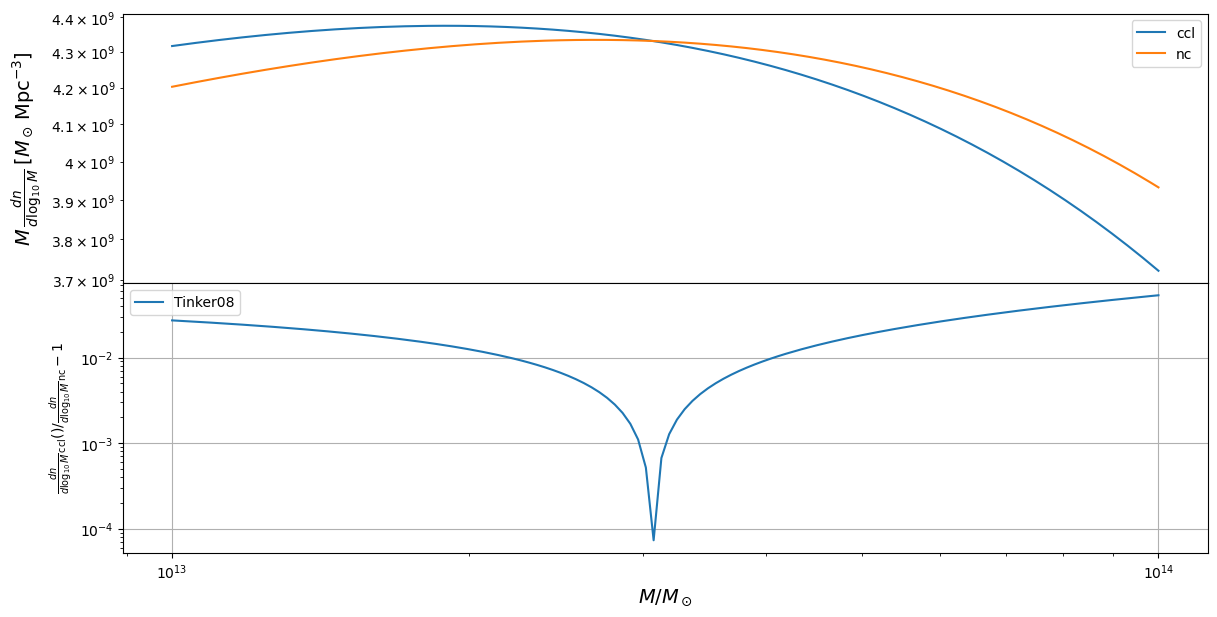

In [6]:
%matplotlib inline
plt.figure()
fig, axs = plt.subplots (2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(14,7))

multiplicity_functions = [(ccl_hmf_T08, hmf)]
#CCL
for ccl_mf_obj, nc_mf_obj in multiplicity_functions:
    ccl_mf = ccl_mf_obj(cosmo_ccl, m_arr, 1.0)
    ccl_nm = m_arr * ccl_mf
    axs[0].plot(m_arr, ccl_nm, label = 'ccl')
    nc_mf = [nc_mf_obj.dn_dlnM (cosmo, logm, 0.0) * math.log(10.0) for logm in np.log(m_arr)]
    
    nc_nm = m_arr * nc_mf
    axs[0].plot(m_arr, nc_nm, label = 'nc')
    
    axs[1].plot (m_arr, np.abs (ccl_nm / nc_nm  - 1.0), '-', label = ccl_mf_obj.name)
    

#Plot settings
axs[0].set_xscale ('log')
axs[0].set_yscale ('log')
#axs[0].ylim([1.0E9,8.5E9])
axs[1].set_yscale ('log')
axs[1].set_xlabel(r'$M/M_\odot$', fontsize=14)
axs[0].set_ylabel(r'$M\,\frac{dn}{d\log_{10}M}\,[M_\odot\,{\rm Mpc}^{-3}]$',
           fontsize=14)
axs[1].set_ylabel(r'$\frac{dn}{d\log_{10}M}_{\mathrm{ccl}} () / \frac{dn}{d\log_{10}M}_{\mathrm{nc}} - 1$')
axs[0].legend(loc='best')

axs[1].legend(loc='best')
axs[1].grid()

fig.show()
plt.show ()

## Emulator


In [7]:
hmf_emu = HMFEmulator(model = "wCDM", mass_def="200c")

In [8]:
cosmo_parameters = {
'Omega_b':Omega_b,
'Omega_m':Omega_c + Omega_b,
'sigma8':sigma8,
'n_s':n_s,
'w': -1,
'h':h,
}

In [18]:
aexp_arr = [1./(1. + z) for z in z_arr]
hmf_vals = hmf_emu.predict_hmf(m_arr, cosmo_parameters, 1.0)

In [19]:
print(len(hmf_vals))

128


## Testing for redshift 1.0
Bear in mind that the emulator has units of M/h. Also their results are in lnM while ccl has logM. NumCosmo is also in lnM and must be corrected by the right factor

### Generating volume elements

In [24]:
a = 1. / 2.
angular_diam_dist = ccl.angular_diameter_distance(cosmo_ccl, a)
h_over_h0 = ccl.h_over_h0(cosmo_ccl, a)

dV = (
    ccl.physical_constants.CLIGHT_HMPC
    * (angular_diam_dist**2)
    * ((1.0) ** 2)
    / (cosmo_ccl["h"] * h_over_h0)
)

sky_area_rad = 489 * (np.pi / 180.0) ** 2
volume = dV * sky_area_rad 
print(volume)

1067231100.6383162


<Figure size 640x480 with 0 Axes>

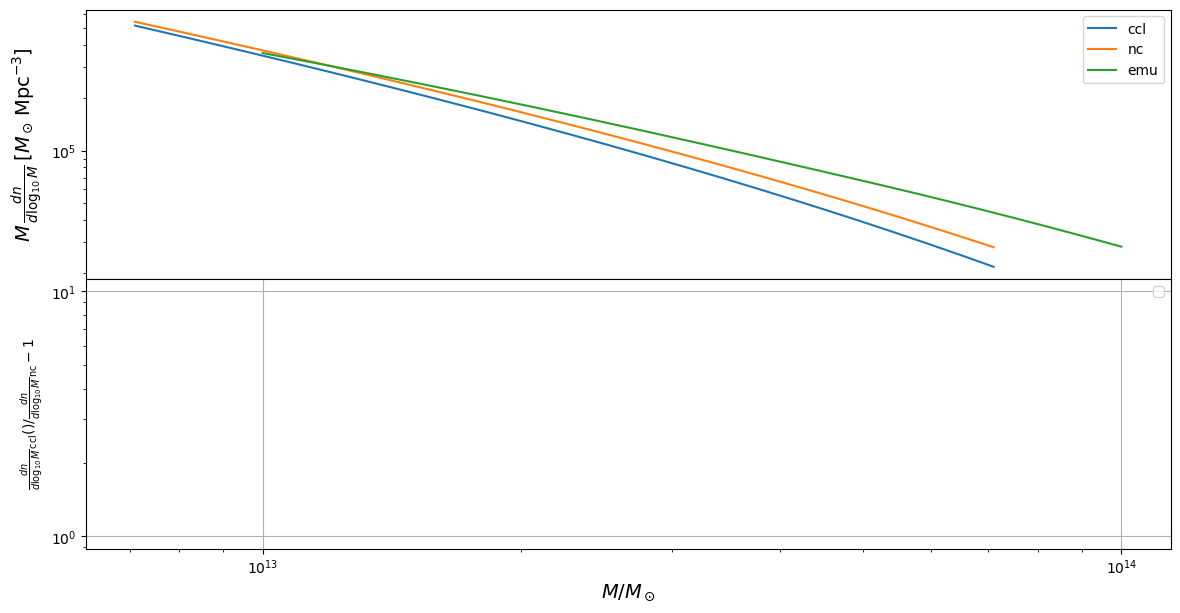

In [34]:
%matplotlib inline
plt.figure()
fig, axs = plt.subplots (2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(14,7))

multiplicity_functions = [(ccl_hmf_T08, hmf)]
#CCL
for ccl_mf_obj, nc_mf_obj in multiplicity_functions:
    ccl_mf = ccl_mf_obj(cosmo_ccl, m_arr * 0.71, a)
    ccl_nm =  ccl_mf * volume
    axs[0].plot(m_arr*0.71, ccl_nm, label = 'ccl')
    nc_mf = [nc_mf_obj.dn_dlnM (cosmo, logm, 1.0)  for logm in np.log(m_arr * 0.71)]
    
    nc_nm =  np.array(nc_mf) * volume * np.log(10)
    emu_nm = np.array(hmf_vals)  * math.log(10.0) * (0.71**3) * volume
    axs[0].plot(m_arr*0.71, nc_nm, label = 'nc')
    axs[0].plot(m_arr, emu_nm, label = 'emu')

    

#Plot settings
axs[0].set_xscale ('log')
axs[0].set_yscale ('log')
#axs[0].ylim([1.0E9,8.5E9])
axs[1].set_yscale ('log')
axs[1].set_xlabel(r'$M/M_\odot$', fontsize=14)
axs[0].set_ylabel(r'$M\,\frac{dn}{d\log_{10}M}\,[M_\odot\,{\rm Mpc}^{-3}]$',
           fontsize=14)
axs[1].set_ylabel(r'$\frac{dn}{d\log_{10}M}_{\mathrm{ccl}} () / \frac{dn}{d\log_{10}M}_{\mathrm{nc}} - 1$')
axs[0].legend(loc='best')

axs[1].legend(loc='best')
axs[1].grid()

fig.show()
plt.show ()